In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image, ImageOps
import cv2
import re

from keras.models import Sequential
from keras.layers import Dense

import keras
from keras import losses
from keras.datasets import mnist
from keras.models import Sequential

from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from keras.models import model_from_json
from keras.optimizers import Adam

Using TensorFlow backend.


In [76]:
# Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

In [77]:
# Loaded a set of images
root_dir = "data/training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(30, len(files)) # Load maximum 20 images
print("Loading " + str(n) + " images")
org_imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
org_gt = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

#n = 12 # Only use 10 images for training

Loading 30 images
satImage_092.png
Loading 30 images
satImage_092.png


In [137]:
# Extract patches from input imagesreflectBorder
patch_size = 16 # each patch is 16*16 pixels

def plotImg (img) :
    fig1 = plt.figure(figsize=(5, 5))
    plt.imshow(img, cmap='Greys_r')

def reflectBorder(im) :
    bordersize = patch_size*2
    border=cv2.copyMakeBorder(im, top=bordersize, bottom=bordersize, left=bordersize, right=bordersize, borderType= cv2.BORDER_REFLECT )
    return border

def rotateImage(pilImg) :
    rotation = [0, 90, 180, 270]
    images = []
    for rot in rotation :
        images.append(pilImg.rotate(rot))
    return images

def mirrorImage(pilImg) :
    return ImageOps.mirror(pilImg)

def imageTrans(pilImges) :
    pilImgRot = []
    for img in pilImges :
        pilImgRot += rotateImage(img)

    pilImgMirror = []
    for img in pilImgRot :
        pilImgMirror += [img, mirrorImage(img)]
    return pilImgMirror

In [79]:
def getImages (imgs) :
    borders = [reflectBorder(img) for img in imgs]
    
    pilImages = [Image.fromarray(img_float_to_uint8(img)) for img in imgs]
    pilImgTrans = imageTrans(pilImages)
    
    imgages = [mpimg.pil_to_array(pilImg) for pilImg in pilImgTrans]  
    return borders

In [80]:
imgs = getImages(org_imgs)
gt_imgs = getImages(org_gt)
len(gt_imgs)

30

Image size = 464,464


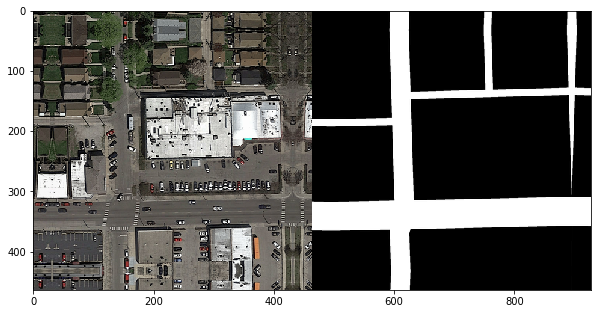

In [136]:
print('Image size = ' + str(imgs[0].shape[0]) + ',' + str(imgs[0].shape[1]))

# Show first image and its groundtruth image
cimg = concatenate_images(imgs[29], gt_imgs[29])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

In [82]:
n

30

In [83]:

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

In [84]:
foreground_threshold = 0.25

# Given an input image 
def image_to_inputs(img, gt):
    rows, cols, _ = img.shape
    
    patches = [
        (
            img[i-2*patch_size:i+3*patch_size, j-2*patch_size:j+3*patch_size, :],
            gt[i:i+patch_size, j:j+patch_size]
        )
        for j in range(2*patch_size, rows - 3*patch_size+1, patch_size)
        for i in range(2*patch_size, cols - 3*patch_size+1, patch_size)
    ]

    return patches

def value_to_class(v):
    df = np.sum(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0

In [85]:
img = image_to_inputs(imgs[0], gt_imgs[0])
len(img)

625

In [86]:
n = len(imgs)
n

30

In [87]:
all_inputs = [inputs for i in range(n) for inputs, _ in image_to_inputs(imgs[i], gt_imgs[i])]
all_gt = [value_to_class(np.mean(gt)) for i in range(n) for _, gt in image_to_inputs(imgs[i], gt_imgs[i])]
X = np.asarray(all_inputs)
y = np.asarray(all_gt)
X.shape

(18750, 80, 80, 3)

In [88]:
def train_test_split(X, y, test_ratio=0.8, seed=42):
    n = len(X)
    np.random.seed(seed)
    idxs = np.random.permutation(n)
    limit = int(test_ratio * n)
    X_train, y_train = X[idxs[:limit]], y[idxs[:limit]]
    X_test, y_test = X[idxs[limit:]], y[idxs[limit:]]
    return X_train, X_test, y_train, y_test

In [89]:
batch_size = 32
#num_classes = 2
epochs = 20

# the data, shuffled and split between train and test sets
x_train, x_test, y_train, y_test  = train_test_split(X, y, 0.8)

In [90]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, 5*patch_size, 5*patch_size)
    x_test = x_test.reshape(x_test.shape[0], 3, 5*patch_size, 5*patch_size)
    input_shape = (3, img_rows, img_cols)
else:
    # We should be here
    x_train = x_train.reshape(x_train.shape[0], 5*patch_size, 5*patch_size, 3)
    x_test = x_test.reshape(x_test.shape[0], 5*patch_size, 5*patch_size, 3)
    input_shape = (5*patch_size, 5*patch_size, 3)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# Already scaled
#x_train /= 255
#x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('input shape', input_shape)

x_train shape: (15000, 80, 80, 3)
15000 train samples
3750 test samples
input shape (80, 80, 3)


In [91]:
model = Sequential()
model.add(Conv2D(batch_size, kernel_size=(5, 5),
                 activation='relu',
                 input_shape=input_shape))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.25))

model.add(Conv2D(batch_size, kernel_size=(4,4), activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.25))

model.add(Flatten())

#model.add(Dense(400, activation='sigmoid'))

model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=1e-3),
              metrics=['accuracy'])


In [92]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          shuffle=True,
          validation_data=(x_test, y_test))

Train on 15000 samples, validate on 3750 samples
Epoch 1/20
15000/15000 [==============================] - 76s - loss: 0.5180 - acc: 0.7429 - val_loss: 0.4771 - val_acc: 0.7715
Epoch 2/20
15000/15000 [==============================] - 80s - loss: 0.4237 - acc: 0.7895 - val_loss: 0.4118 - val_acc: 0.8067
Epoch 3/20
15000/15000 [==============================] - 83s - loss: 0.3803 - acc: 0.8177 - val_loss: 0.3585 - val_acc: 0.8261
Epoch 4/20
15000/15000 [==============================] - 75s - loss: 0.3386 - acc: 0.8450 - val_loss: 0.3883 - val_acc: 0.8080
Epoch 5/20
15000/15000 [==============================] - 75s - loss: 0.3106 - acc: 0.8589 - val_loss: 0.3298 - val_acc: 0.8592
Epoch 6/20
15000/15000 [==============================] - 76s - loss: 0.2800 - acc: 0.8761 - val_loss: 0.3159 - val_acc: 0.8552
Epoch 7/20
15000/15000 [==============================] - 75s - loss: 0.2547 - acc: 0.8897 - val_loss: 0.3201 - val_acc: 0.8565
Epoch 8/20
15000/15000 [==============================]

In [125]:
score = model.evaluate(x_test, y_test, verbose=1, batch_size=batch_size)
print('Test loss:', score[0])
print('Test acc:', score[1])

3750/3750 [==============================] - 5s     
Test loss: 0.229660068925
Test acc: 0.905333333302


In [126]:
img_idx  = 29
pred_image = [inputs for inputs, _ in image_to_inputs(imgs[img_idx], gt_imgs[img_idx])]
predictions = model.predict(np.asarray(pred_image), verbose=1)

625/625 [==============================] - 0s     


In [127]:
pred_image[0].shape

(80, 80, 3)

In [128]:
gt_imgs[0].shape

(464, 464)

In [129]:
print('model ouput size: ', predictions.shape)
predictions = predictions.reshape((25, 25))
print('new size: ', predictions.shape)
predictions_aug = np.zeros((25, 25))
predictions_aug[0:25, 0:25] = predictions
predictions_aug.shape

model ouput size:  (625, 1)
new size:  (25, 25)


(25, 25)

In [130]:
# Convert array of labels to an image

def label_to_img(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            im[j:j+w, i:i+h] = labels[idx]
            idx = idx + 1
    return im

def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img
    

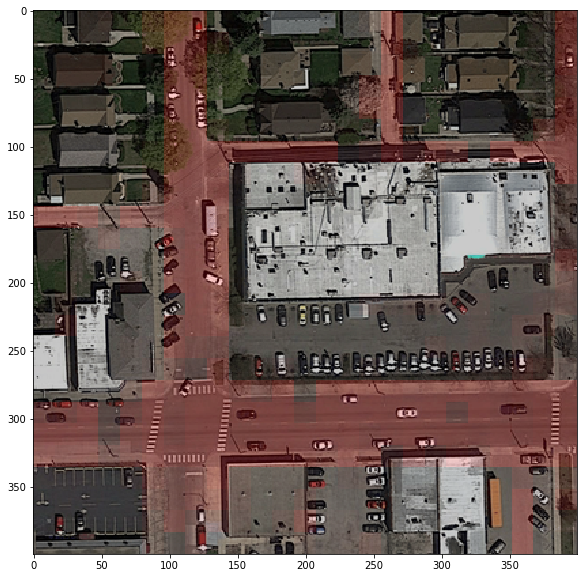

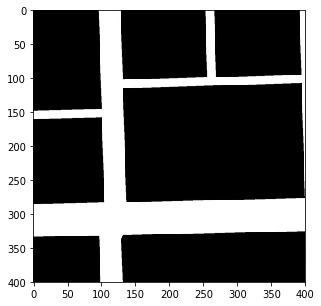

In [140]:
# Display prediction as an image

w = org_gt[img_idx].shape[0]
h = org_gt[img_idx].shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, [elem for lst in predictions for elem in lst])
cimg = concatenate_images(org_imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = make_img_overlay(org_imgs[img_idx], predicted_im)

plt.imshow(new_img)

plotImg(org_gt[29])

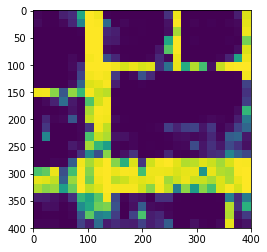

In [141]:
plt.imshow(predicted_im)

In [142]:
# assign a label to a patch
def patch_to_label(patch):
    df = np.mean(patch)
    if df > foreground_threshold:
        return 1
    else:
        return 0


def mask_to_submission_strings(img):
    """Reads a single image and outputs the strings that should go into the submission file"""
    im = img
    patch_size = 16
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch)
            yield("{:03d}_{}_{},{}".format(0, j, i, label))


def masks_to_submission(submission_filename, *images):
    """Converts images into a submission file"""
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for fn in images[0:]:
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(fn))

In [143]:
# save the model and the weights to files
# the path is : /Users/VIPu/DATA/EPFL/Sem9/CS433_MachineLearning/projet2/epfml17-segmentation/savedModels/
model_json = model.to_json()
f = open('/Users/VIPu/DATA/EPFL/Sem9/CS433_MachineLearning/projet2/epfml17-segmentation/savedModels/model_2', 'w')
f.write(model_json)
f.close()
model.save_weights('/Users/VIPu/DATA/EPFL/Sem9/CS433_MachineLearning/projet2/epfml17-segmentation/savedModels/weights_2')



FileNotFoundError: [Errno 2] No such file or directory: '/Users/VIPu/DATA/EPFL/Sem9/CS433_MachineLearning/projet2/epfml17-segmentation/savedModels/model_2'

In [119]:
# load model to test
fm = open('/Users/VIPu/DATA/EPFL/Sem9/CS433_MachineLearning/projet2/epfml17-segmentation/savedModels/model_2')
model_2 = model_from_json(fm.read())
model_2.load_weights('/Users/VIPu/DATA/EPFL/Sem9/CS433_MachineLearning/projet2/epfml17-segmentation/savedModels/weights_2', by_name=False)
fm.close()

model_2.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model_2.evaluate(x_test, y_test, verbose=1, batch_size=batch_size)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/VIPu/DATA/EPFL/Sem9/CS433_MachineLearning/projet2/epfml17-segmentation/savedModels/model_2'